# SAMBA (demo & diagnostics)

### import dependencies

In [1]:
import warnings
import jax # use for autodifferentiation
import jax.numpy as jnp
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants
from scipy.interpolate import interp1d
from plasmapy.particles import Particle
from plasmapy.formulary import collision_frequency, thermal_speed, Coulomb_logarithm
from IPython.display import clear_output

### global settings

In [2]:
# JAX configuration
#jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
# matplotlib params
#mpl.style.use("dark_background")
mpl.rcParams['axes.formatter.limits'] = (-2,2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams["axes.titlesize"] = 32
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.facecolor"] = "black"
#plt.rcParams.keys()
palette = sb.color_palette("rainbow_r")
palette

[(1.0, 0.4291206087726087, 0.2199463578396685),
 (0.9274509803921569, 0.7829276104921029, 0.43467642176596505),
 (0.6450980392156862, 0.9741386021045102, 0.622112816721474),
 (0.3549019607843138, 0.9741386021045101, 0.7829276104921028),
 (0.0725490196078431, 0.7829276104921027, 0.9005867023006374),
 (0.2176470588235293, 0.4291206087726091, 0.9755119679804366)]

## **I. Generate B field**

### magnetic vector potential

$$\vec{A} = B_{min} \frac{r}{2} b ^ \frac{2(dz)^2}{d^4 + z^4} \hat{\theta}$$

$$\vec{B} = \nabla \times A = \nabla \times A_{\theta} = -\frac{\partial A_\theta}{\partial z} \hat{r} + \frac{1}{r} \frac{\partial}{\partial r} (rA_{\theta}) \hat{z}$$

$$B_r = -\frac{\partial A_\theta}{\partial z} = \frac{2 B_{min} d^2 r z \log(b) (z^4 - d^4) b^\frac{2(dz)^2}{z^4 + d^4}} {(z^4 + d^4)^2}$$

$$r\hat{r} = x\hat{x} + y\hat{y} \rightarrow B_x = \frac{x}{r}B_r, B_y = \frac{y}{r}B_r$$

$$B_x = \frac{2 B_{min} d^2 x z \log(b) (z^4 - d^4) b^\frac{2(dz)^2}{z^4 + d^4}} {(z^4 + d^4)^2}$$

$$B_y = \frac{2 B_{min} d^2 y z \log(b) (z^4 - d^4) b^\frac{2(dz)^2}{z^4 + d^4}} {(z^4 + d^4)^2}$$

$$B_z = \frac{1}{r} \frac{\partial}{\partial r} (rA_{\theta}) = B_{min} b ^ \frac{2(dz)^2}{d^4 + z^4}$$

### B field parameters (and radius of bottle)

In [3]:
# basal B-field value on axis (z={0, -inf, +inf})
B_0 = 1e-3 # T 
# bottle end B-field multipliers (must be float)
b_neg = 5
b_pos = 5
# distance (m) from bottle ends to origin (must be float)
d_neg = 1
d_pos = 1                       
# Radius of mirror machine
R = 0.25
# parameters for piecewise B-field function
params = (B_0, b_neg, b_pos, d_neg, d_pos)

### B field components

In [4]:
# B_x and B_z are equivalent to B_r, just replace r
def B_r(r, z, B_0, b, d):
    temp1 = 2 * B_0 * d ** 2 * r * z * jnp.log(b)
    temp2 = z ** 4 - d ** 4
    temp3 = z ** 4 + d ** 4
    temp4 = 2 * (z * d) ** 2
    return temp1 * temp2 * b ** (temp4 / temp3) / temp3 ** 2

def B_z(z, B_0, b, d):
    return B_0 * b ** (2 * (z * d) ** 2 / (z ** 4 + d ** 4))

def get_B(x, y, z, params):
    B_0, b_neg, b_pos, d_neg, d_pos = params
    neg = jnp.array([z, B_0, b_neg, d_neg])
    pos = jnp.array([z, B_0, b_pos, d_pos])
    args = jnp.where(z < 0, neg, pos)
    return jnp.array([B_r(x, *args), B_r(y, *args), B_z(*args)])

def VB_polar(r, z, params):
    B_0, b_neg, b_pos, d_neg, d_pos = params
    # build masks
    neg = jnp.array(tuple([n < 0 for n in z]))
    pos = ~neg
    # vectorize
    VB_r = jnp.vectorize(B_r)
    VB_z = jnp.vectorize(B_z)
    # seperate z<0 and z>=0
    Br = jnp.zeros(len(r))
    Br = Br.at[neg].set(VB_r(r[neg], z[neg], B_0, b_neg, d_neg))
    Br = Br.at[pos].set(VB_r(r[pos], z[pos], B_0, b_pos, d_pos))
    Bz = jnp.zeros(len(z))
    Bz = Bz.at[neg].set(VB_z(z[neg], B_0, b_neg, d_neg))
    Bz = Bz.at[pos].set(VB_z(z[pos], B_0, b_pos, d_pos))
    return jnp.array([Br, Bz])

def VB_cartesian(x, y, z, params):
    B_0, b_neg, b_pos, d_neg, d_pos = params
    # build masks
    neg = jnp.array(tuple([n < 0 for n in z]))
    pos = ~neg
    # vectorize
    VB_r = jnp.vectorize(B_r)
    VB_z = jnp.vectorize(B_z)
    # seperate z<0 and z>=0
    Bx = jnp.zeros(len(x))
    Bx = Bx.at[neg].set(VB_r(x[neg], z[neg], B_0, b_neg, d_neg))
    Bx = Bx.at[pos].set(VB_r(x[pos], z[pos], B_0, b_pos, d_pos))
    By = jnp.zeros(len(y))
    By = By.at[neg].set(VB_r(y[neg], z[neg], B_0, b_neg, d_neg))
    By = By.at[pos].set(VB_r(y[pos], z[pos], B_0, b_pos, d_pos))
    Bz = jnp.zeros(len(z))
    Bz = Bz.at[neg].set(VB_z(z[neg], B_0, b_neg, d_neg))
    Bz = Bz.at[pos].set(VB_z(z[pos], B_0, b_pos, d_pos))
    return jnp.array([Bx, By, Bz])

### gradient of |B|

$$\nabla B = \frac{\partial B}{\partial x} \hat{x} + \frac{\partial B}{\partial y} \hat{y} + \frac{\partial B}{\partial z} \hat{z}$$

In [5]:
def B_scalar(x, y, z, params):
    return jnp.linalg.norm(get_B(x, y, z, params))

def grad_B(x, y, z, params):
    args = (x, y, z, params)
    gradBx = jax.grad(B_scalar, argnums=0)(*args)
    gradBy = jax.grad(B_scalar, argnums=1)(*args)
    gradBz = jax.grad(B_scalar, argnums=2)(*args)
    return jnp.array([gradBx, gradBy, gradBz])

def Vgrad_B(x, y, z, params):
    return jax.vmap(grad_B, in_axes=(0, 0, 0, None))(x, y, z, params)

### plot B field

In [6]:
# B-field values on axis (r=0)
r_range1 = jnp.linspace(0, 1.5 * R, 100)
z_range1 = jnp.linspace(-1.5 * d_neg, 1.5 * d_pos, 100)
z_fig1 = jnp.linspace(z_range1[0], z_range1[-1], 250)
r_fig1 = jnp.zeros_like(z_fig1)
Bz_fig1 = VB_polar(r_fig1, z_fig1, params)[1]
z_fig1_interp = jnp.linspace(z_range1[0], z_range1[-1], 150)
Bz_fig1_interp = interp1d(z_fig1, Bz_fig1, kind="quadratic")(z_fig1_interp)
# create B vector field for r, z
r_grid2, z_grid2 = jnp.meshgrid(r_range1, z_range1)
r_fig2 = r_grid2.ravel()
z_fig2 = z_grid2.ravel()
Br_fig2, Bz_fig2 = VB_polar(r_fig2, z_fig2, params)
Br_fig2_rs = Br_fig2.reshape(r_grid2.shape).T
Bz_fig2_rs = Bz_fig2.reshape(z_grid2.shape).T
B_fig2 = jnp.sqrt(jnp.add(jnp.square(Br_fig2_rs), jnp.square(Bz_fig2_rs)))

(0.0, 0.375)

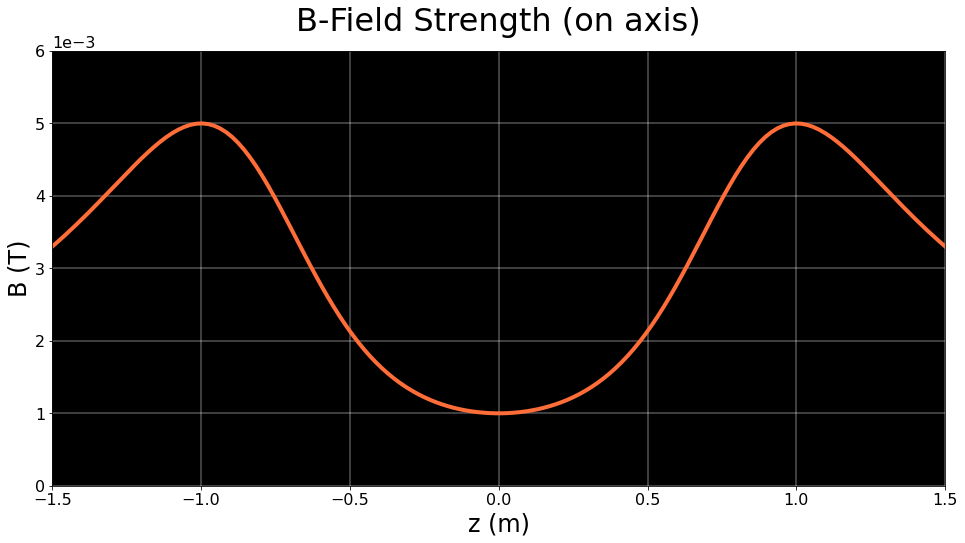

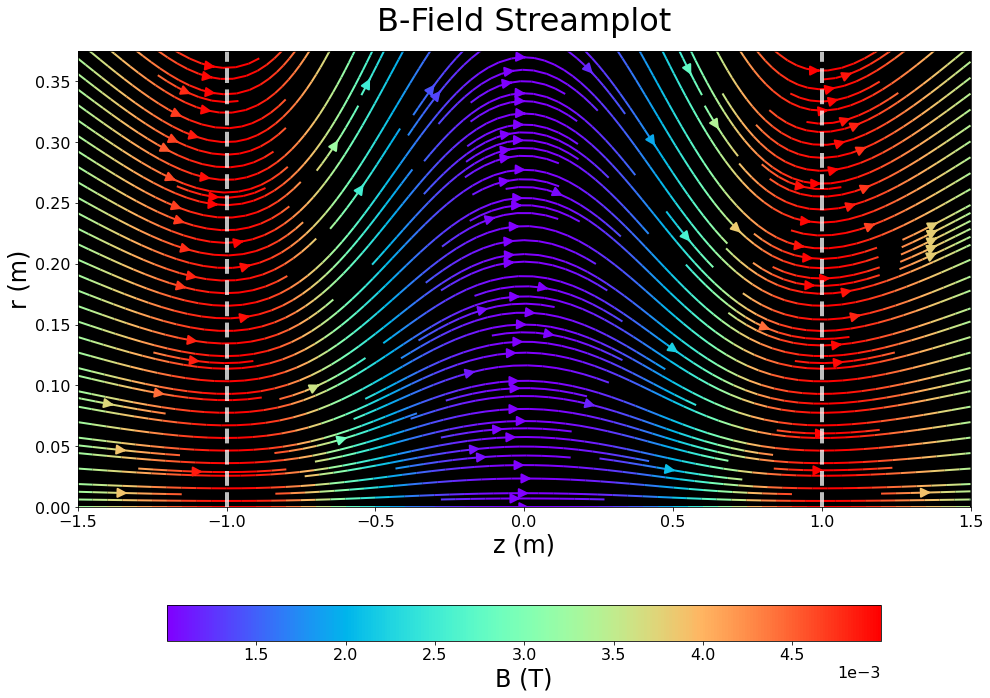

In [7]:
# figure 1
plt.figure(figsize=(16, 8))
plt.plot(z_fig1_interp, Bz_fig1_interp, 
         color=palette[0], linewidth=4)
plt.grid(color='w', linestyle='-', linewidth=2, alpha=0.25, zorder=-1)
plt.title("B-Field Strength (on axis)")
plt.xlabel("z (m)")
plt.ylabel("B (T)")
plt.xlim((z_fig1[0], z_fig1[-1]))
plt.ylim((0, (max(b_neg, b_pos) + 1) * B_0));
# figure 2
plt.figure(figsize=(16, 12))
# convert jnp arrays to np arrays for streamplot (or MatPlotLib won't play nicely)
plt.streamplot(np.array(z_range1), np.array(r_range1), 
               np.array(Bz_fig2_rs), np.array(Br_fig2_rs),
               color=np.array(B_fig2), cmap="rainbow",
               density=2, linewidth=2, arrowsize=2)
plt.colorbar(label="B (T)", orientation="horizontal", shrink=0.8)
plt.vlines([-d_neg, d_pos], 0, r_range1[-1], lw=4, ls="--", color="white", alpha=0.75, zorder=2)
plt.title("B-Field Streamplot")
plt.xlabel("z (m)")
plt.ylabel("r (m)")
plt.xlim((z_range1[0], z_range1[-1]))
plt.ylim((0, r_range1[-1]))

## **II. Simulation Functions and Parameters**

### Boris push algorithm

In [8]:
def boris(X, V, B, dt, q, m, _0, _1):
    """
    Input: position half step ahead of velocity
    Output: position and velocity in sync
    """
    U = q / m * B * dt / 2
    W = 2 * U / (1 + jnp.dot(U, U))
    V_prime = V + jnp.cross(V, U)
    V_new = V + jnp.cross(V_prime, W)
    X_new = X + V_new * dt / 2
    return (X_new, V_new)

### energy conserving pitch angle scattering pusher

In [9]:
def coulomb(X, V, B, dt, q, m, nu_collision, v_thermal):
    """
    Zhang, Fu, & Chin 2020/2022
    """
    v_norm = jnp.linalg.norm(V)
    D = nu_collision * v_thermal ** 3 / v_norm
    dW = np.random.normal(0, jnp.sqrt(dt), size=(3))
    temp1 = jnp.sqrt(D) * jnp.cross(V, dW) / (2 * v_norm ** 2)
    temp2 = q / m * B * dt / 2
    M = temp1 - temp2
    M_hat = jnp.array([[   0 , -M[2],  M[1]], 
                       [ M[2],    0 , -M[0]], 
                       [-M[1],  M[0],    0]])
    temp3 = jnp.identity(3) - M_hat
    temp4 = jnp.identity(3) + M_hat
    caley = jnp.matmul(jnp.linalg.inv(temp3), temp4)
    V_new = jnp.matmul(caley, V)
    X_new =  X + V_new * dt / 2
    return X_new, V_new

### calculate guiding center and magnetic moment

In [10]:
def mu_gc(X, V, B, q, m, params):
    B_norm = jnp.linalg.norm(B)
    B_sqrd = jnp.square(B_norm)
    V_para = jnp.dot(V, B) / B_sqrd * B
    V_perp = V - V_para
    V_para_norm = jnp.linalg.norm(V_para)
    V_perp_norm = jnp.linalg.norm(V_perp)
    V_cross_B = jnp.cross(V, B)
    V_cross_B_norm = jnp.linalg.norm(V_cross_B)
    gyrohat = V_cross_B / V_cross_B_norm
    gyrorad = m * V_perp_norm / (q * B_norm)
    gc = jnp.add(X, gyrorad * gyrohat)
    B_gc = get_B(*gc, params)
    B_gc_norm = jnp.linalg.norm(B_gc)
    mu = m * V_perp_norm ** 2 / (2 * B_gc_norm)
    # many quantities in this function are useful to return
    return (mu, gc, B_gc, B_gc_norm, jnp.abs(gyrorad), V_para_norm, V_perp_norm)

# vectorized version
def Vmu_gc(X, V, B, q, m, params):
    return jax.vmap(mu_gc, in_axes=(0, 0, 0, None, None, None))(X, V, B, q, m, params)

### density gradient

In [11]:
def density(X, n_0, R):
    r = jnp.linalg.norm((X[0], X[1]))
    n = n_0.value * (1 - (r / R) ** 2)# * B / B_0
    return jnp.where(r < R, n, 0) / u.m ** 3

### choose pusher

In [12]:
pusher = boris
#pusher = coulomb

### plasma parameters

In [13]:
particle_a = Particle("electron")
particle_b = Particle("proton")

n_0 = 1e21 / u.m ** 3 # at origin
T = 1 * u.keV

# calculate thermal velocity
# ignore relativistic warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    v_therm = thermal_speed(T, particle_a).value # m / s
print(f"thermal velocity: {v_therm:.5e} m/s")

thermal velocity: 1.87554e+07 m/s


### initial parameters

In [14]:
v = v_therm
theta = 45 * jnp.pi / 180 # pitch
phi = 0 * jnp.pi / 180 # phase

### initial state

In [15]:
# initialize velocity
v_p = v * jnp.sin(theta) #v_perp
v_x = v_p * jnp.cos(phi)
v_y = v_p * jnp.sin(phi)
v_z = v * jnp.cos(theta) # v_parallel for z = 0
V_0 = jnp.array([v_x, v_y, v_z])
# initialize position
r_gyro = particle_a.mass.value * v_p / particle_a.charge.value / jnp.linalg.norm(get_B(0, 0, 0, params))
X_0 = jnp.array([0, r_gyro, 0])
r_gyro

DeviceArray(-0.07540312, dtype=float64)

### initial collision frequency

In [16]:
# ignore relativistic warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    nu_0 = collision_frequency(T, n_0, (particle_a, particle_b)).value # Hz
t_collision = 1 / nu_0

print(f"collision time: {t_collision:.5e} s")

collision time: 5.57030e-07 s


### validate collision frequency equation

In [17]:
print(nu_0)

1795234.2213958737


In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ln_lambda = Coulomb_logarithm(T, n_0, (particle_a, particle_b))
print(ln_lambda)

14.694336979179864


In [19]:
m1 = constants.m_e.value # kg
q1 = constants.e.value # C
q2 = constants.e.value # C
e0 = constants.eps0.value # F / m
c = constants.c.value # m / s
gamma = 1 / np.sqrt(1 - v_therm ** 2 / c ** 2)
numer = 4 * np.pi * n_0.to(1 / u.m ** 3).value * (q1 * q2) ** 2 * ln_lambda
denom = (4 * np.pi * e0 * gamma * m1) ** 2 * v_therm ** 3
print(numer / denom)

1788240.9797434586


### plot plasma density gradient

(0.0, 0.3125)

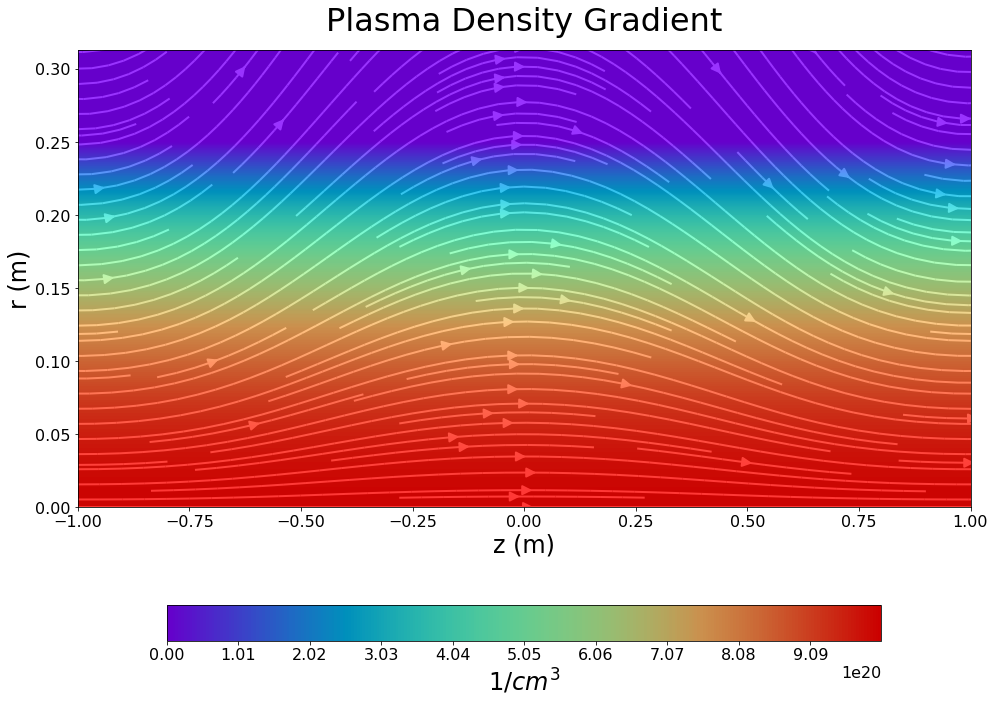

In [20]:
plt.figure(figsize=(16, 12))
# manually calculate density gradient, TODO: fix this
n_fig = n_0.value * (1 - (r_grid2 / R) ** 2) * jnp.ones_like(B_fig2)
#n_fig = n_0.value * (1 - (r_grid2 / R) ** 2) * B_fig2 / B_0
n_fig = n_fig.at[r_grid2 >= R].set(0)
levels=np.arange(0.0, 1.01 * jnp.max(n_fig), n_0.value/1000)
plt.streamplot(np.array(z_range1), np.array(r_range1), 
               np.array(Bz_fig2_rs), np.array(Br_fig2_rs),
               density=2, linewidth=2, arrowsize=2, color="white", zorder=0)
plt.contourf(z_grid2, r_grid2, n_fig, levels=levels, cmap="rainbow", alpha=0.8)
plt.colorbar(label="$1 / cm^3$", orientation="horizontal", shrink=0.8)
plt.title("Plasma Density Gradient")
plt.xlabel("z (m)")
plt.ylabel("r (m)")
plt.xlim((-d_neg, d_pos))
plt.ylim((0, 1.25 * R))

# **III. Calculate Particle Trajectory**

### duration of simulation (and step limit)

In [21]:
duration = 1 * t_collision
max_steps = int(1e5)

### run simulation

In [22]:
# get particle a charge and mass
q_a = particle_a.charge.value
m_a = particle_a.mass.value
# create and initialize particle state arrays
X_traj = jnp.empty((max_steps, 3))
V_traj = jnp.empty((max_steps, 3))
T_traj = jnp.empty(max_steps)
# initialize state
X_traj = X_traj.at[0].set(X_0)
V_traj = V_traj.at[0].set(V_0)
# initialize counters
t = 0
step = 0 
# for diagnostics
w_gyro = []
n_sp = []
nu_sp = []
# find B-field at X starting position
X_ahead = X_0
B_traj = get_B(*X_ahead, params)
while t < duration: # and -d_neg < X_ahead[2] and X_ahead[2] < d_pos:
    # find local gyrofrequency
    B_traj_norm = jnp.linalg.norm(B_traj)
    w_traj = abs(q_a) * B_traj_norm / m_a
    # 1/4 radian per time step
    dt = 1 / w_traj / 4
    # step position 1/2 step ahead of velocity using current velocity
    X_ahead = jnp.add(X_traj[step], V_traj[step] * dt / 2)
    # Find local B-field and push particle
    B_traj = get_B(*X_ahead, params)
    n = density(X_ahead, n_0, R) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        nu = collision_frequency(T, n, (particle_a, particle_b))
    X_next, V_next = pusher(X_ahead, V_traj[step], B_traj, dt, q_a, m_a, nu, v_therm)
    # update arrays
    X_traj = X_traj.at[step + 1].set(X_next)
    V_traj = V_traj.at[step + 1].set(V_next)
    T_traj = T_traj.at[step].set(t)
    w_gyro.append(w_traj)
    n_sp.append(n.value)
    nu_sp.append(nu.value)
    # update counters
    step += 1
    t += dt
    # show progress
    clear_output(wait=True)
    progress = int(100 * t / duration)
    print(progress * "#", (100 - progress) * " ", progress, "%")

####################################################################################################  100 %


In [23]:
# trim unused tail of arrays    
X_sp = X_traj[:step]
V_sp = V_traj[:step]
T_sp = T_traj[:step]  

print(f"steps: {step}")

steps: 564


### calculate guiding center,  $\mu$, & deviation from $\mu_0$

$$\mu = \frac{m v_{\perp}^2}{2B} [A m^2]$$

$$A m^2 = \frac{N m}{T} = \frac{J}{T}$$

$$\frac{\Delta\mu}{\mu_0} = \frac{\mu(t) - \mu_0}{\mu_0}$$

In [24]:
# more iterations for better accuracy 
iterations = 3
# approximate guiding center
B_gc = VB_cartesian(*X_sp.T, params).T
for i in range(iterations):
    mu, gc, B_gc, B_gc_norm, gyrorad, v_para, v_perp = Vmu_gc(X_sp, V_sp, B_gc, q_a, m_a, params)
    clear_output(wait=True)
    progress = int(100 * (i + 1) / iterations)
    print(progress * "#", (100 - progress) * " ", progress, "%")

####################################################################################################  100 %


### interpolate trajectory & guiding center

In [25]:
time = np.arange(T_sp[4], T_sp[-4], step=duration/1e6)
# sp = single particle
x_sp = interp1d(T_sp, X_sp[:, 0], kind="cubic")(time)
y_sp = interp1d(T_sp, X_sp[:, 1], kind="cubic")(time)
z_sp = interp1d(T_sp, X_sp[:, 2], kind="cubic")(time)
# gc = guiding center
x_gc = interp1d(T_sp, gc[:, 0], kind="cubic")(time)
y_gc = interp1d(T_sp, gc[:, 1], kind="cubic")(time)
z_gc = interp1d(T_sp, gc[:, 2], kind="cubic")(time)
# radial components
r_sp = jnp.linalg.norm((x_sp, y_sp), axis=0)
r_gc = jnp.linalg.norm((x_gc, y_gc), axis=0)

# **III. Plot Exploration**

### trajectory plots

Text(0, 0.5, 'y (m)')

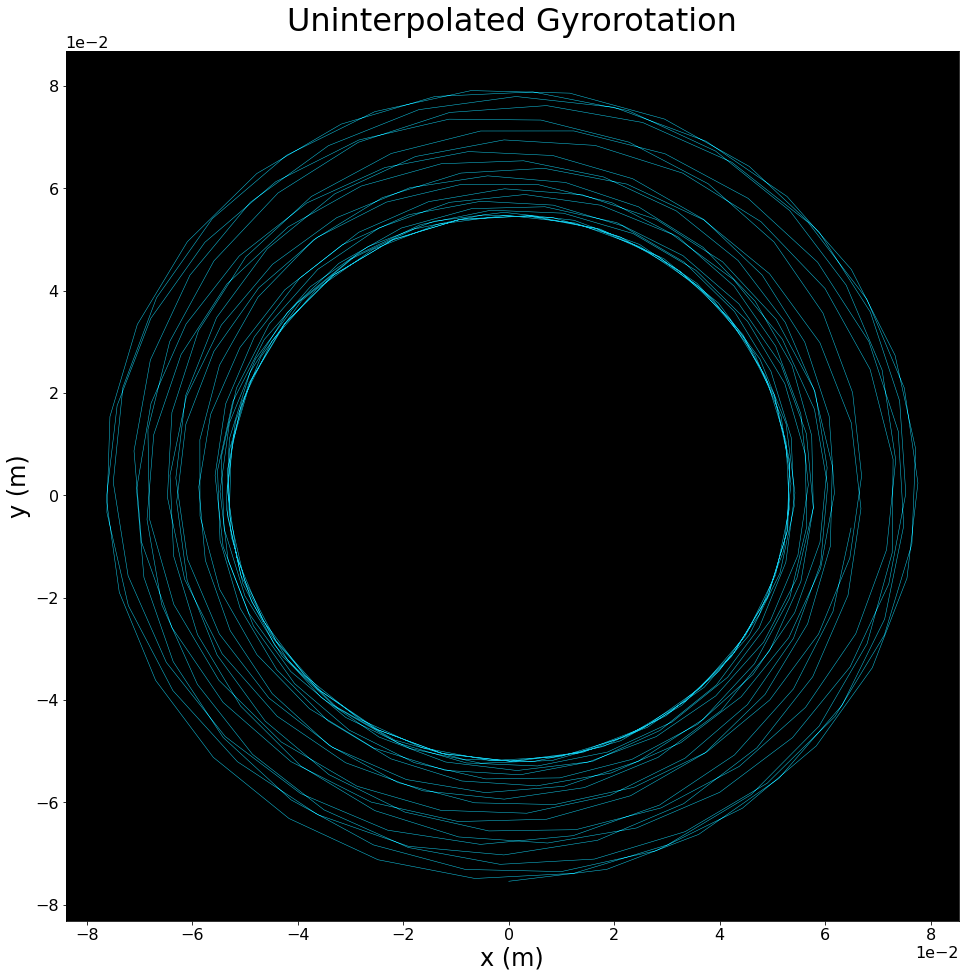

In [26]:
plt.figure(figsize=(16, 16))
plt.plot(X_sp[:, 0], X_sp[:, 1], linewidth=0.5, c=palette[4])
plt.title("Uninterpolated Gyrorotation")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

Text(0, 0.5, 'y (m)')

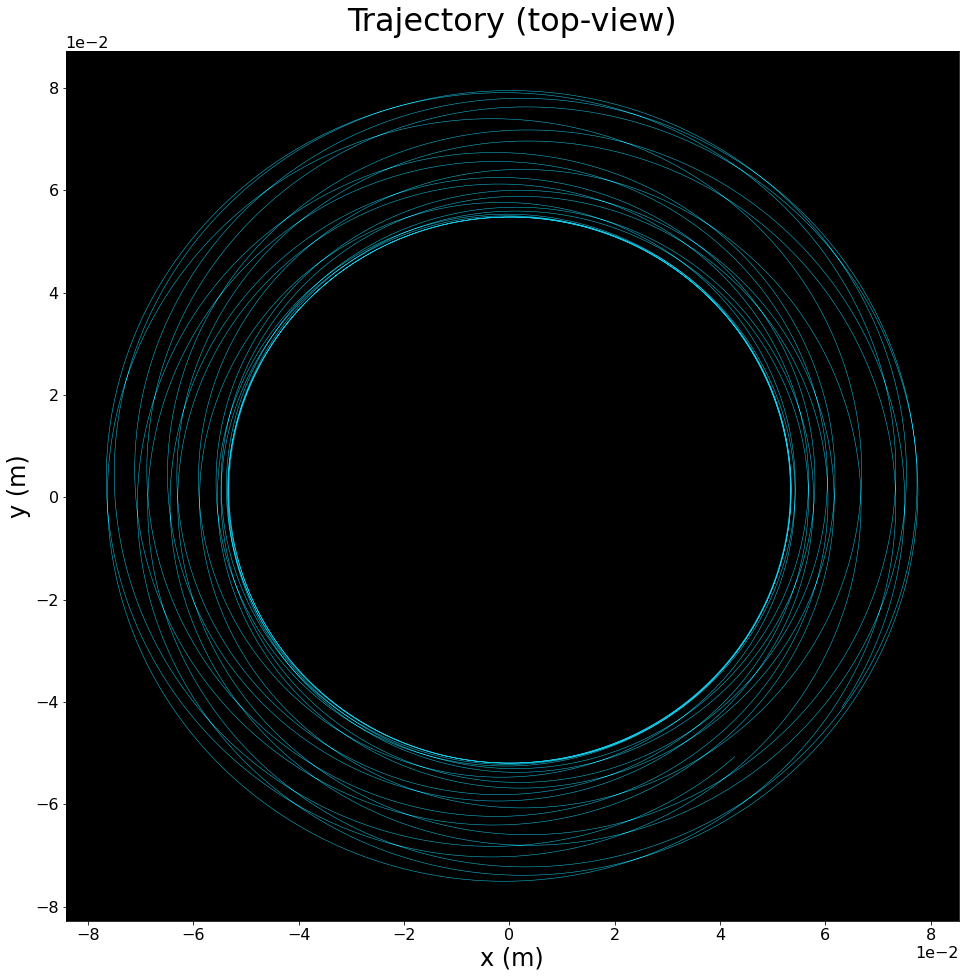

In [27]:
plt.figure(figsize=(16, 16))
plt.plot(x_sp, y_sp, linewidth=0.5, c=palette[4])
plt.title("Trajectory (top-view)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

Text(0, 0.5, 'x (m)')

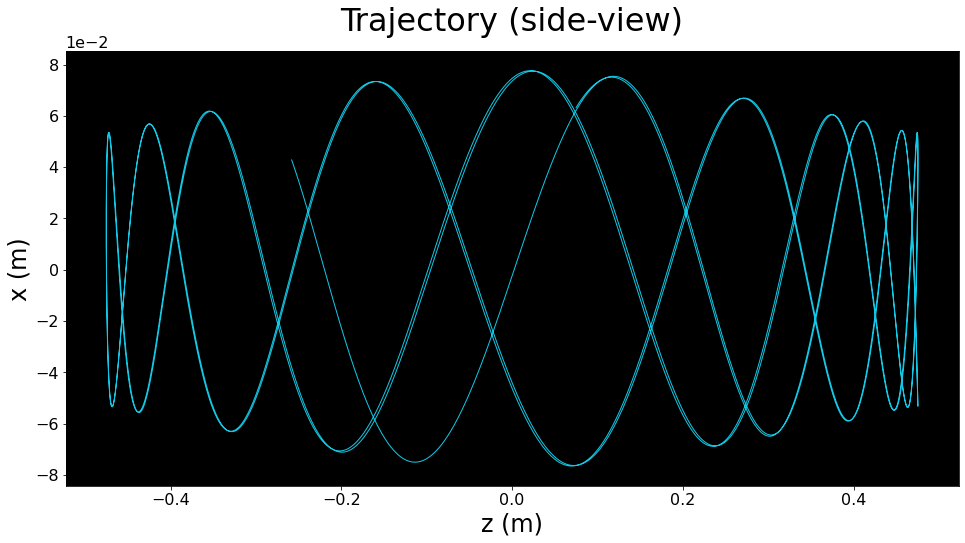

In [28]:
plt.figure(figsize=(16, 8))
plt.plot(z_sp, x_sp, linewidth=1, c=palette[4])
plt.title("Trajectory (side-view)")
plt.xlabel("z (m)")
plt.ylabel("x (m)")

Text(0, 0.5, 'z (m)')

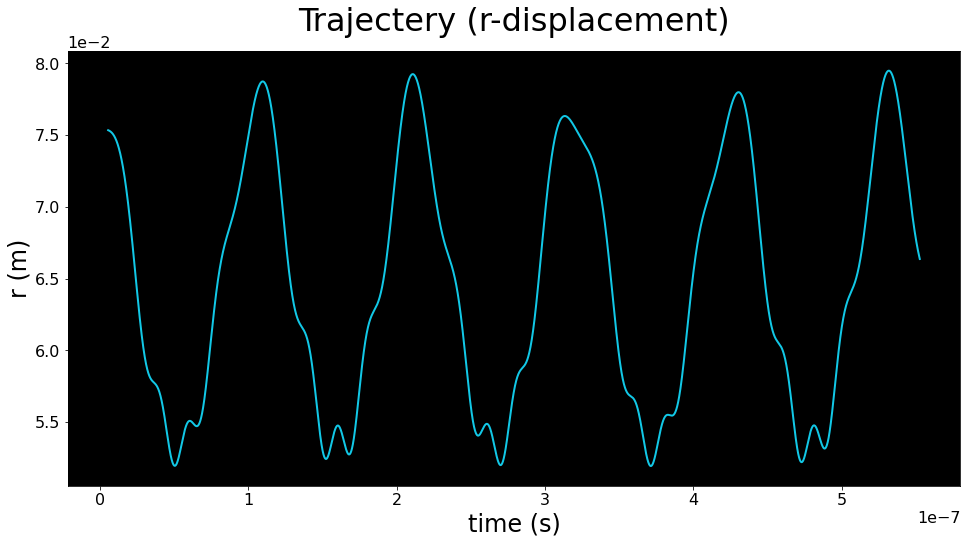

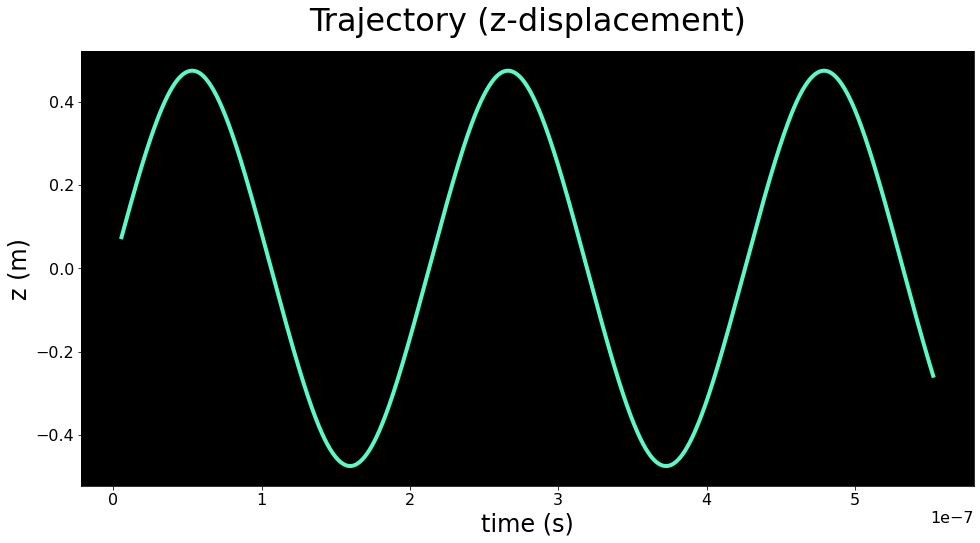

In [29]:
plt.figure(figsize=(16, 8))
plt.plot(time, r_sp, linewidth=2, c=palette[4])
plt.title("Trajectery (r-displacement)")
plt.xlabel("time (s)")
plt.ylabel("r (m)")
plt.figure(figsize=(16, 8))
plt.plot(time, z_sp, linewidth=4, c=palette[3])
plt.title("Trajectory (z-displacement)")
plt.xlabel("time (s)")
plt.ylabel("z (m)")

# guiding center plots

Text(0, 0.5, 'y (m)')

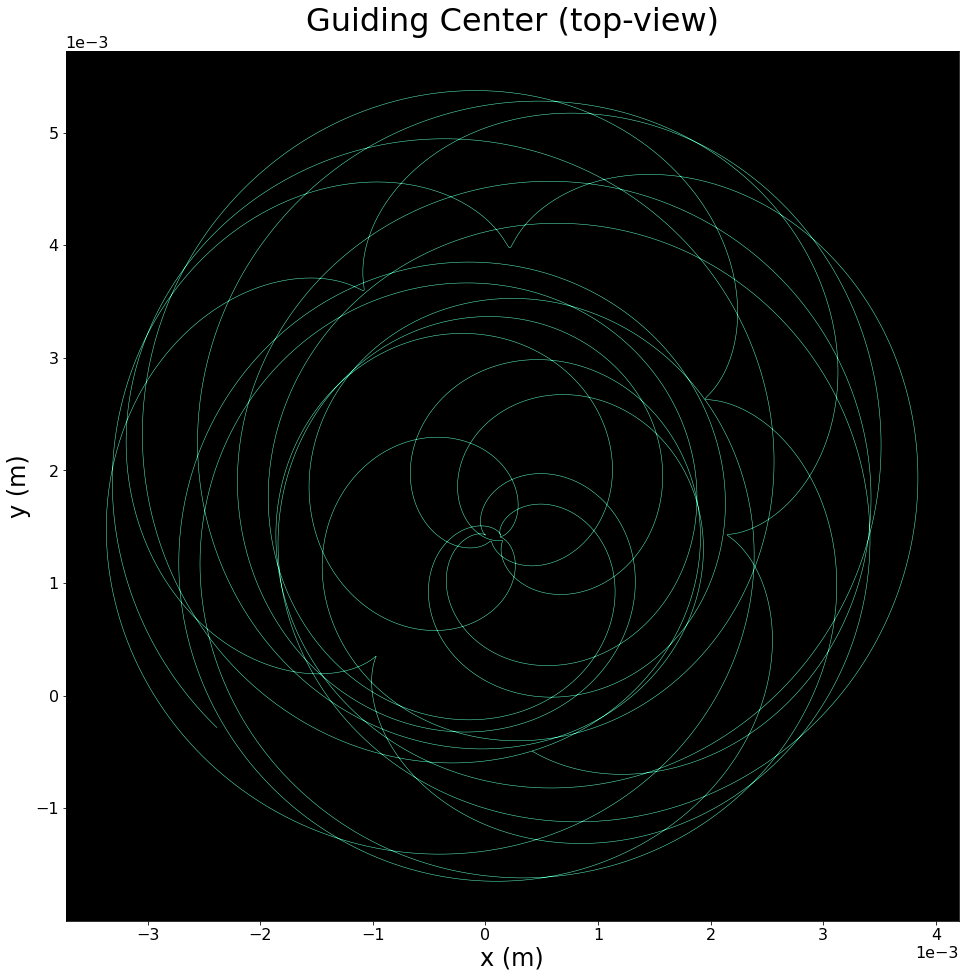

In [30]:
plt.figure(figsize=(16, 16))
plt.plot(x_gc, y_gc, linewidth=0.5, c=palette[3])
plt.title("Guiding Center (top-view)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

Text(0, 0.5, 'x (m)')

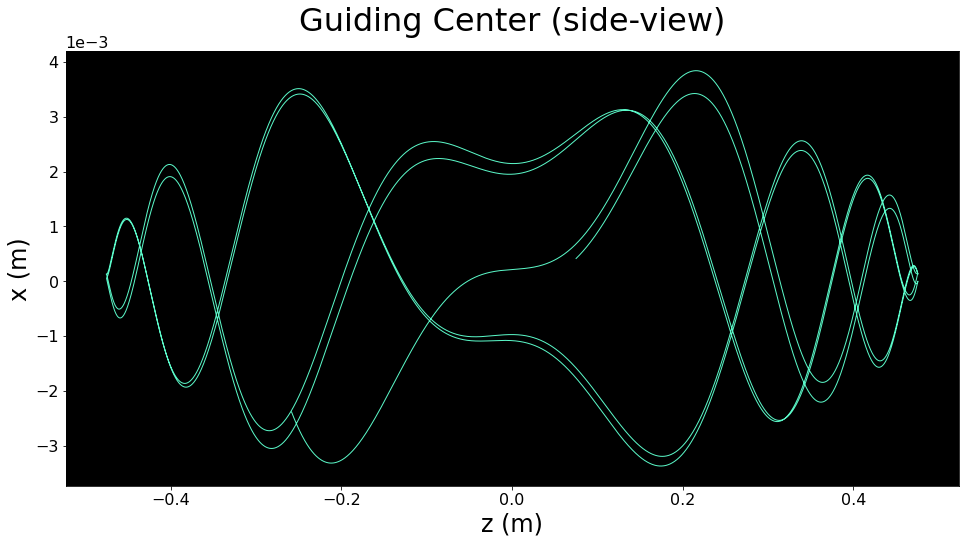

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(z_gc, x_gc, linewidth=1, c=palette[3])
plt.title("Guiding Center (side-view)")
plt.xlabel("z (m)")
plt.ylabel("x (m)")

Text(0, 0.5, 'z (m)')

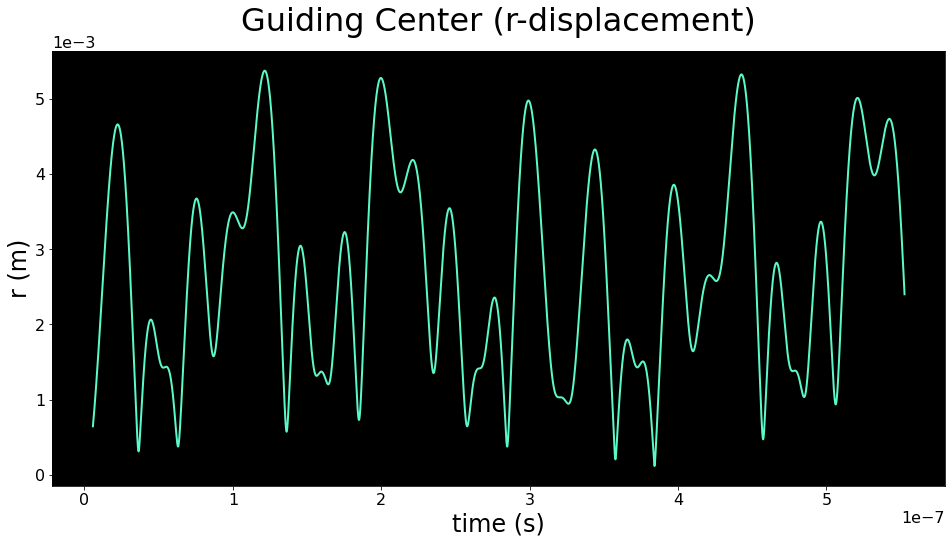

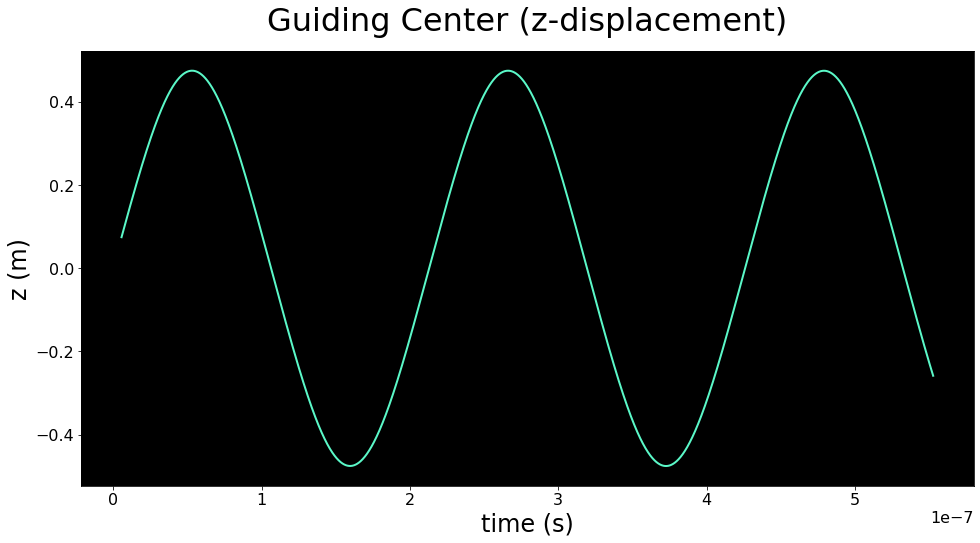

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(time, r_gc, linewidth=2, c=palette[3])
plt.title("Guiding Center (r-displacement)")
plt.xlabel("time (s)")
plt.ylabel("r (m)")
plt.figure(figsize=(16, 8))
plt.plot(time, z_gc, linewidth=2, c=palette[3])
plt.title("Guiding Center (z-displacement)")
plt.xlabel("time (s)")
plt.ylabel("z (m)")

(-0.09699363130405439, 0.09699363130405439)

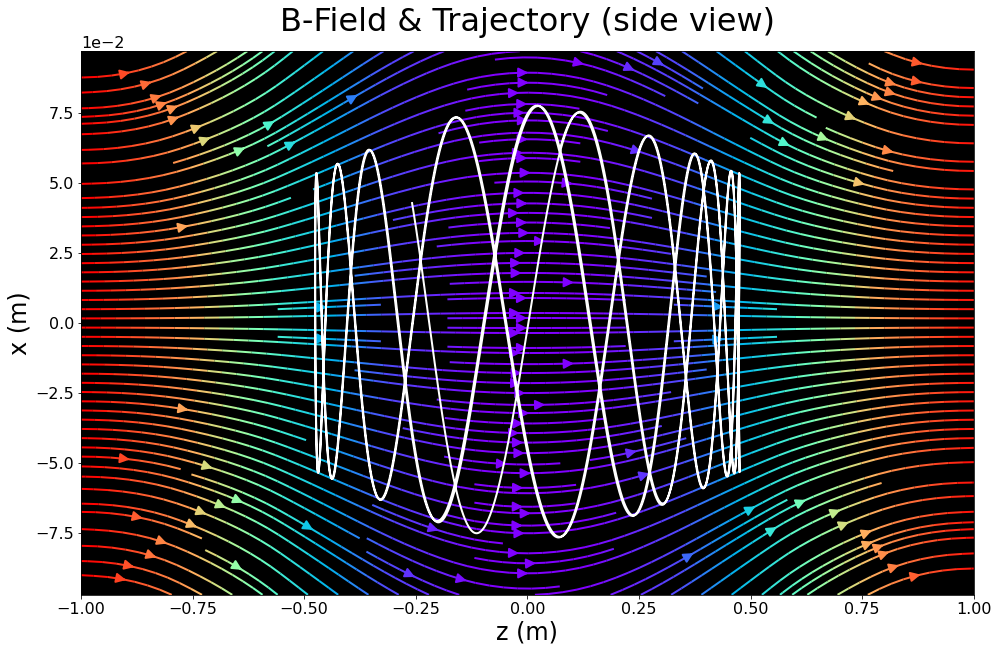

In [33]:
xlim3 = 1.25 * max(jnp.abs(jnp.min(x_sp)), jnp.max(x_sp))
x_range3 = jnp.linspace(-xlim3, xlim3, 10)
z_range3 = jnp.linspace(-d_neg, d_pos, 10)
x_fig3, z_fig3 = jnp.meshgrid(x_range3, z_range3)
Bx_fig3, _, Bz_fig3 = VB_cartesian(x_fig3.ravel(), jnp.zeros_like(x_fig3).ravel(),
                                   z_fig3.ravel(), params)
Bx_fig3 = Bx_fig3.reshape(x_fig3.shape).T
Bz_fig3 = Bz_fig3.reshape(z_fig3.shape).T
B_fig3 = jnp.sqrt(jnp.add(jnp.square(Bx_fig3), jnp.square(Bz_fig3)))
plt.figure(figsize=(16, 10))
plt.streamplot(np.array(z_range3), np.array(x_range3), 
               np.array(Bz_fig3), np.array(Bx_fig3),
               color=np.array(B_fig3), cmap="rainbow",
               density=2, linewidth=2, arrowsize=2)
plt.plot(z_sp, x_sp, linewidth=2, c="white")
plt.title("B-Field & Trajectory (side view)")
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.xlim((z_range3[0], z_range3[-1]))
plt.ylim((x_range3[0], x_range3[-1]))

## **IV. Diagnostics**

### velocity space

Text(0, 0.5, '$V_{\\perp}$')

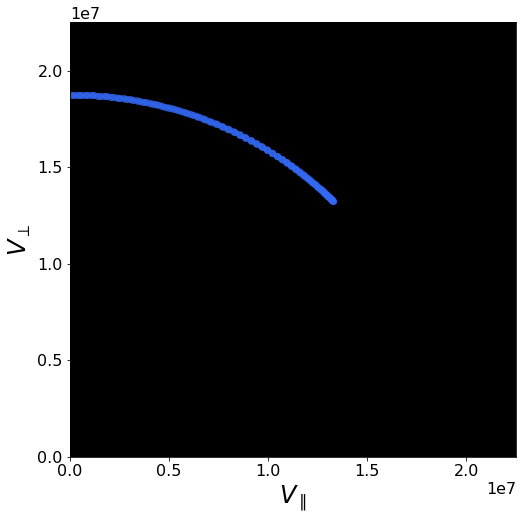

In [34]:
plt.figure(figsize=(8, 8))
plt.scatter(v_para, v_perp, alpha=0.2, c=palette[5])
plt.xlim(0, 1.2 * v_therm)
plt.ylim(0, 1.2 * v_therm)
plt.xlabel("$V_{\parallel}$")
plt.ylabel("$V_{\perp}$")

### energy

$$E = W_{\perp} + W_{\parallel}$$

$$\mu = \frac{m v_{\perp}^2}{2 |B|} = \frac{W_{\perp}}{|B|}$$

$$E = \mu |B| + W_{\parallel}$$

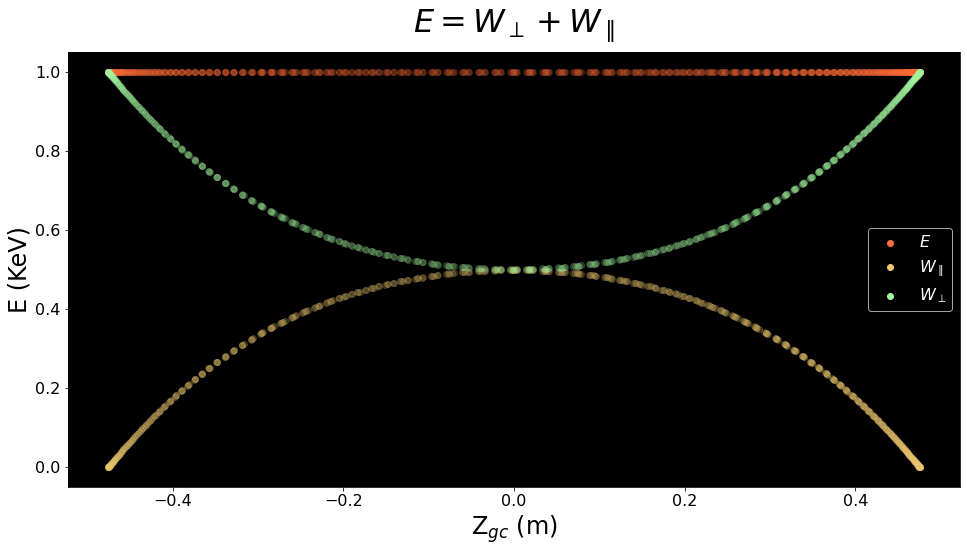

In [44]:
W_para = m_a / 2 * jnp.square(v_para) / 1.602e-16 # J --> KeV
W_perp = m_a / 2 * jnp.square(v_perp) / 1.602e-16 # J --> KeV
W = W_para + W_perp # KeV

plt.figure(figsize=(16, 8))
plt.scatter(gc[:, 2], W, alpha=0.2, c=palette[0])
plt.scatter(gc[:, 2], W_para, alpha=0.2, c=palette[1])
plt.scatter(gc[:, 2], W_perp, alpha=0.2, c=palette[2])
#plt.ylim(0, 1.2 * max(W))
plt.title("$E = W_{\perp} + W_{\parallel}$")
plt.xlabel("Z$_{gc}$ (m)")
plt.ylabel("E (KeV)")
leg = plt.legend(["$E$", "$W_{\parallel}$", "$W_{\perp}$"], labelcolor="white")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

### Hall parameter

Text(0.5, 0, 'time (s)')

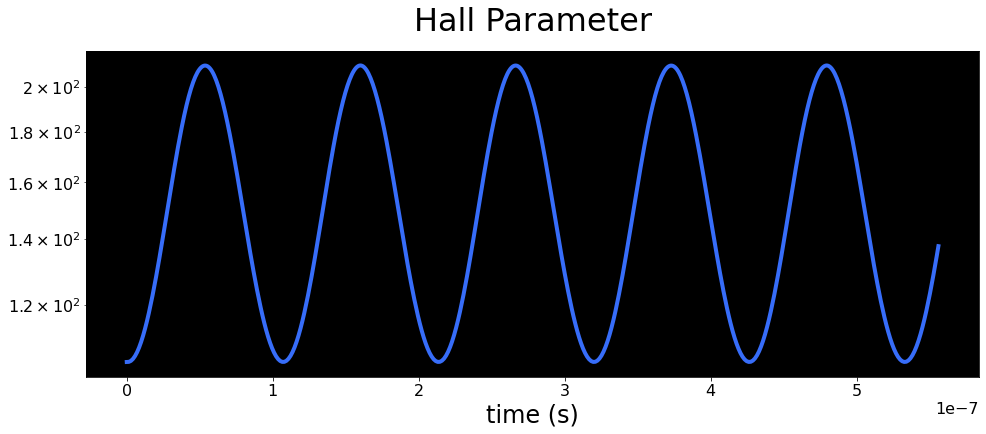

In [36]:
plt.figure(figsize=(16, 6))
plt.semilogy(T_sp, w_gyro / nu, linewidth=4, c=palette[5])
#plt.ylim(1e-5, 1e4)
plt.title("Hall Parameter")
plt.xlabel("time (s)")
#plt.legend(["$freq_{gyro} / freq_{collsion}$"], labelcolor="white")

### Length Scale

$$\frac{r_{gyro}}{L} = r_{gyro} \frac{|\nabla B|}{|B|} \ll 1$$

In [37]:
gradB_gc = Vgrad_B(*gc.T, params)
gradB_gc_norm = jnp.linalg.norm(gradB_gc, axis=1)
L = B_gc_norm / gradB_gc_norm
rL = gyrorad / L

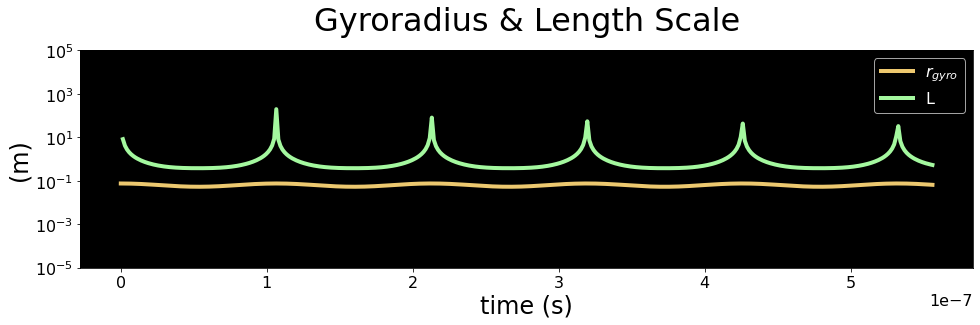

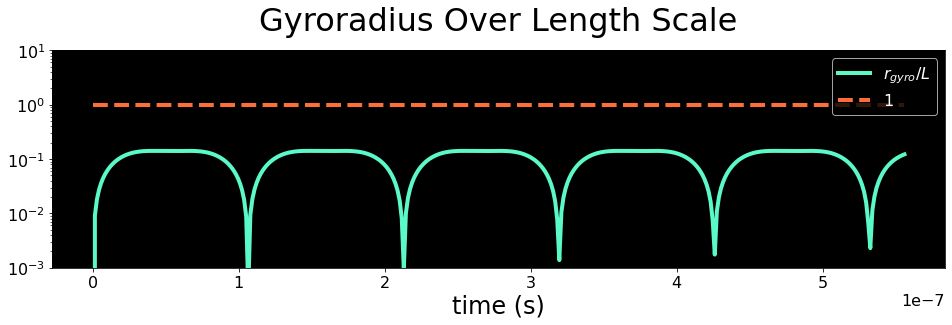

In [52]:
plt.figure(figsize=(16, 4))
plt.semilogy(T_sp, gyrorad, lw=4, c=palette[1])
plt.semilogy(T_sp, L, lw=4, c=palette[2])
plt.ylim(1e-5, 1e5)
plt.title("Gyroradius & Length Scale")
plt.xlabel("time (s)")
plt.ylabel("(m)")
plt.legend(["$r_{gyro}$", "L"], labelcolor="white")
plt.figure(figsize=(16, 4))
plt.semilogy(T_sp, rL, lw=4, c=palette[3])
plt.hlines(1, jnp.min(T_sp), jnp.max(T_sp), lw=4, ls="--", color=palette[0])
plt.ylim(1e-3, 10)
plt.title("Gyroradius Over Length Scale")
plt.xlabel("time (s)")
plt.legend(["$r_{gyro} / L$", "1"], labelcolor="white")

### magnetic moment $\mu$

In [39]:
# find deviation from mu_0
mu_dev = (mu - mu[0]) / mu[0]
print(max(mu_dev))

0.0028489796051875405


(-0.004202491672968768, 0.004303218094955751)

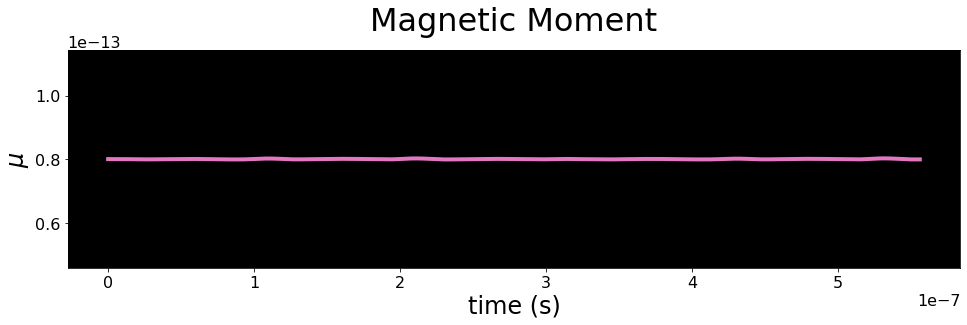

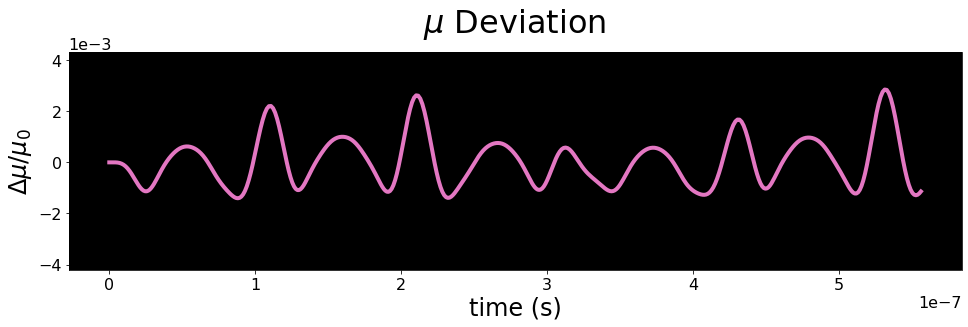

In [47]:
range_mu = jnp.max(mu) - jnp.min(mu)
range_mu_dev = jnp.max(mu_dev) - jnp.min(mu_dev)

plt.figure(figsize=(16, 4))
plt.plot(T_sp, mu, linewidth=4, c="C6")
plt.title("Magnetic Moment")
plt.xlabel("time (s)")
plt.ylabel("$\mu$")
plt.ylim(jnp.mean(mu) - 100 * range_mu, jnp.mean(mu) + 100 * range_mu)

plt.figure(figsize=(16, 4))
plt.plot(T_sp, mu_dev, linewidth=4, c="C6")
plt.title("$\mu$ Deviation")
plt.xlabel("time (s)")
plt.ylabel("$\Delta \mu / \mu_0$")
plt.ylim(jnp.mean(mu_dev) - range_mu_dev, jnp.mean(mu_dev) + range_mu_dev)

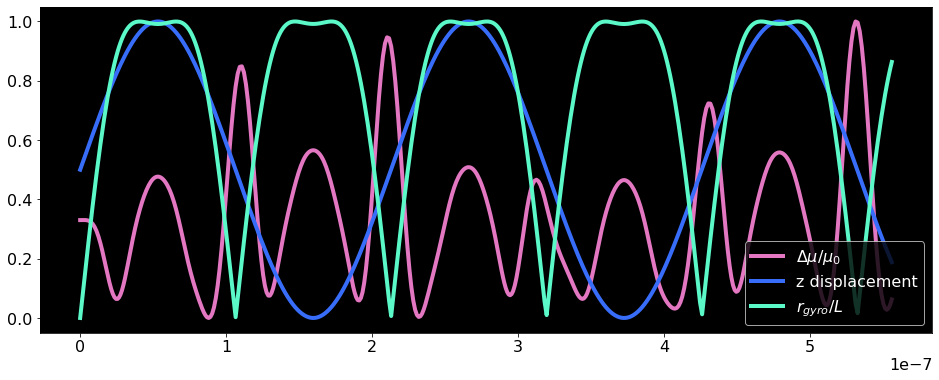

In [41]:
z_norm = (X_sp[:, 2] - jnp.min(X_sp[:, 2])) / (jnp.max(X_sp[:, 2]) - jnp.min(X_sp[:, 2]))
rL_norm = (rL - jnp.min(rL)) / (jnp.max(rL) - jnp.min(rL))
mu_norm = (mu - jnp.min(mu)) / (jnp.max(mu) - jnp.min(mu))

plt.figure(figsize=(16, 6))
plt.plot(T_sp, mu_norm, linewidth=4, c="C6")
plt.plot(T_sp, z_norm, linewidth=4, c=palette[5])
plt.plot(T_sp, rL_norm, lw=4, c=palette[3])

#plt.ylim(-0.2, 1)
plt.legend(["$\Delta \mu / \mu_0$", "z displacement","$r_{gyro} / L$"], labelcolor="white")

Text(0, 0.5, 'Hz')

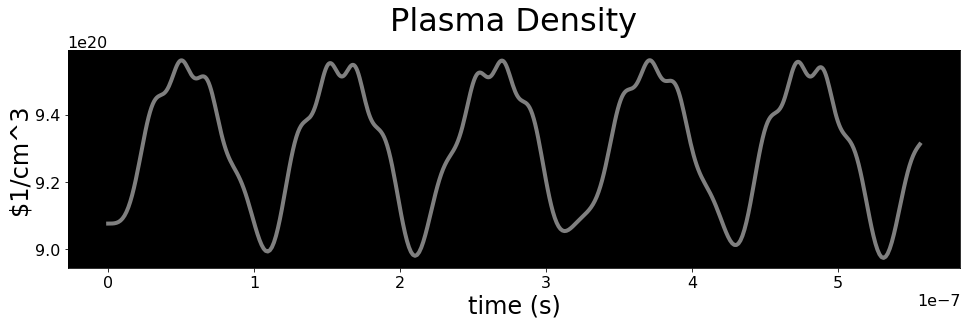

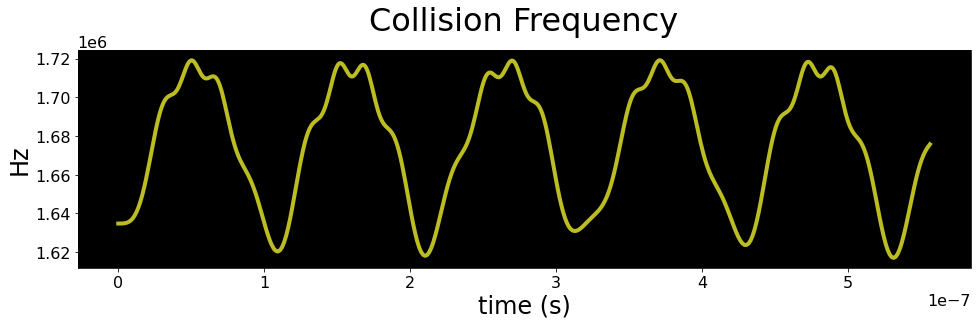

In [42]:
plt.figure(figsize=(16, 4))
plt.plot(T_sp, np.array(n_sp), linewidth=4, c="C7")
plt.title("Plasma Density")
plt.xlabel("time (s)")
plt.ylabel("$1/cm^3")

plt.figure(figsize=(16, 4))
plt.plot(T_sp, nu_sp, linewidth=4, c="C8")
plt.title("Collision Frequency")
plt.xlabel("time (s)")
plt.ylabel("Hz")

Text(0.5, 0, 'time (s)')

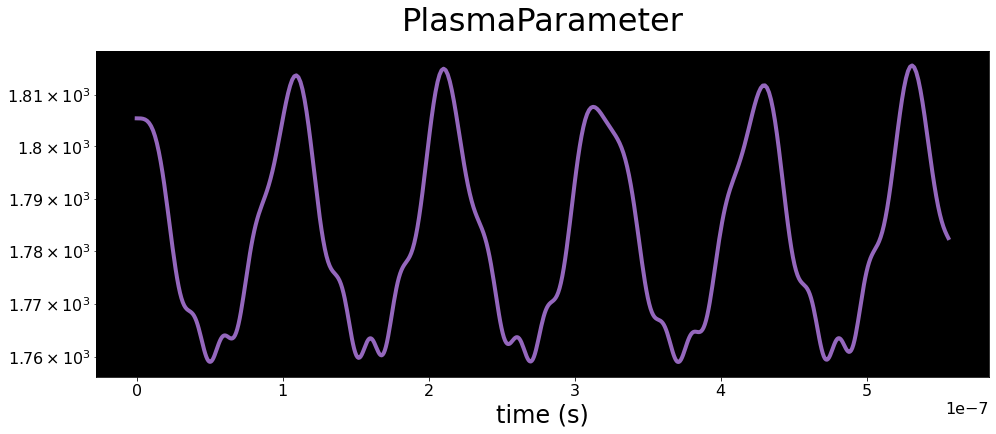

In [43]:
T_eV = 1e3 * T # keV --> eV
plasma_param = 1.72e9 * T_eV ** (3 / 2) / np.sqrt(n_sp)

plt.figure(figsize=(16, 6))
plt.semilogy(T_sp,plasma_param, linewidth=4, c="C4")
#plt.ylim(1e-5, 1e4)
plt.title("PlasmaParameter")
plt.xlabel("time (s)")